# План исследования:
1. Загрузка и подготовка данных
2. Обучение и проверка модели
3. Подготовка к расчёту прибыли
4. Расчёт приьыли и рисков
5. Выводы

In [1]:
# импортируем необходимые для работы библиотеки.
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
sns.set_style("whitegrid")
plt.rcParams["figure.figsize"] = (10, 6)

import statsmodels.api as sm

from statsmodels.stats.outliers_influence import variance_inflation_factor

from sklearn.model_selection import train_test_split
from sklearn.pipeline import make_pipeline
from sklearn.preprocessing import StandardScaler
from sklearn.linear_model import LinearRegression
from sklearn.metrics import mean_squared_error

from numpy.random import RandomState

RANDOM=42
state=RandomState(RANDOM)
TEST_SIZE=0.25

# убираем предупреждения Pandas Future warning 
import warnings
warnings.simplefilter(action='ignore', category=FutureWarning)

In [2]:
# функция для построения ящика с усами
def data_boxplot (df, column, title):
    
    fig, (ax_box, ax_hist) = plt.subplots(
        2, sharex=True, 
        gridspec_kw={"height_ratios": (.15, .85)},
        figsize=(8, 6)
    )

    sns.boxplot(x=df[column], ax=ax_box)
    sns.histplot(x=df[column], bins=12, kde=True, stat='density', ax=ax_hist)
    
    fig.suptitle(f"{title} {column}", fontsize=16)
    
    ax_box.set(yticks=[])
    sns.despine(ax=ax_hist)
    sns.despine(ax=ax_box, left=True)
    plt.xticks(rotation=45)
    
    plt.show()
    
    q1 = df[column].quantile(0.25).round(1)
    q3 = df[column].quantile(0.75).round(1)
    IQR = q3 - q1
    
    print(f"медиана: {df[column].median()} \n"
          f"среднее: {df[column].mean().round(1)} \n"
          f"min: {df[column].min()} \n"
          f"max: {df[column].max()} \n"
          f"верхний порог выбросов: {(q3 + 1.5 * IQR).round(2)} \n"
          f"нижний порог выбросов: {(q1 - 1.5 * IQR).round(2)} \n"
          f"Q1: {q1} \n"
          f"Q3: {q3}"
         )
    
# функция для работы с выбросами
def remove_outliers(data, column_name):
    q1 = data[column_name].quantile(0.25)
    q3 = data[column_name].quantile(0.75)
    iqr = q3 - q1
    
    lower_bound = q1 - 1.5 * iqr
    upper_bound = q3 + 1.5 * iqr


    outlier_indices = data[
        (data[column_name] < lower_bound) | (data[column_name] > upper_bound)
    ].index.tolist()

    print(f"количество удалённых строк: {len(outlier_indices)}")
    return outlier_indices

## Загрузка и подготовка данных

In [3]:
try:
    district_0 = pd.read_csv('D:\docs\DS\\geo_data_0.csv')
    district_1 = pd.read_csv('D:\docs\DS\\geo_data_1.csv')
    district_2 = pd.read_csv('D:\docs\DS\\geo_data_2.csv')
except:
    district_0 = pd.read_csv('https://code.s3.yandex.net/datasets/geo_data_0.csv')
    district_1 = pd.read_csv('https://code.s3.yandex.net/datasets/geo_data_1.csv')
    district_2 = pd.read_csv('https://code.s3.yandex.net/datasets/geo_data_2.csv')

In [4]:
district_0.info()
district_0.head()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 100000 entries, 0 to 99999
Data columns (total 5 columns):
 #   Column   Non-Null Count   Dtype  
---  ------   --------------   -----  
 0   id       100000 non-null  object 
 1   f0       100000 non-null  float64
 2   f1       100000 non-null  float64
 3   f2       100000 non-null  float64
 4   product  100000 non-null  float64
dtypes: float64(4), object(1)
memory usage: 3.8+ MB


,id,f0,f1,f2,product
0,txEyH,0.705745,-0.497823,1.221170,105.280062
1,2acmU,1.334711,-0.340164,4.365080,73.037750
2,409Wp,1.022732,0.151990,1.419926,85.265647
3,iJLyR,-0.032172,0.139033,2.978566,168.620776
4,Xdl7t,1.988431,0.155413,4.751769,154.036647


In [5]:
district_0.describe()

,f0,f1,f2,product
count,100000.000000,100000.000000,100000.000000,100000.000000
mean,0.500419,0.250143,2.502647,92.500000
std,0.871832,0.504433,3.248248,44.288691
min,-1.408605,-0.848218,-12.088328,0.000000
25%,-0.072580,-0.200881,0.287748,56.497507
50%,0.502360,0.250252,2.515969,91.849972
75%,1.073581,0.700646,4.715088,128.564089
max,2.362331,1.343769,16.003790,185.364347


In [6]:
district_1.info()
district_1.head()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 100000 entries, 0 to 99999
Data columns (total 5 columns):
 #   Column   Non-Null Count   Dtype  
---  ------   --------------   -----  
 0   id       100000 non-null  object 
 1   f0       100000 non-null  float64
 2   f1       100000 non-null  float64
 3   f2       100000 non-null  float64
 4   product  100000 non-null  float64
dtypes: float64(4), object(1)
memory usage: 3.8+ MB


,id,f0,f1,f2,product
0,kBEdx,-15.001348,-8.276000,-0.005876,3.179103
1,62mP7,14.272088,-3.475083,0.999183,26.953261
2,vyE1P,6.263187,-5.948386,5.001160,134.766305
3,KcrkZ,-13.081196,-11.506057,4.999415,137.945408
4,AHL4O,12.702195,-8.147433,5.004363,134.766305


In [7]:
district_1.describe()

,f0,f1,f2,product
count,100000.000000,100000.000000,100000.000000,100000.000000
mean,1.141296,-4.796579,2.494541,68.825000
std,8.965932,5.119872,1.703572,45.944423
min,-31.609576,-26.358598,-0.018144,0.000000
25%,-6.298551,-8.267985,1.000021,26.953261
50%,1.153055,-4.813172,2.011479,57.085625
75%,8.621015,-1.332816,3.999904,107.813044
max,29.421755,18.734063,5.019721,137.945408


In [8]:
district_2.info()
district_2.head()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 100000 entries, 0 to 99999
Data columns (total 5 columns):
 #   Column   Non-Null Count   Dtype  
---  ------   --------------   -----  
 0   id       100000 non-null  object 
 1   f0       100000 non-null  float64
 2   f1       100000 non-null  float64
 3   f2       100000 non-null  float64
 4   product  100000 non-null  float64
dtypes: float64(4), object(1)
memory usage: 3.8+ MB


,id,f0,f1,f2,product
0,fwXo0,-1.146987,0.963328,-0.828965,27.758673
1,WJtFt,0.262778,0.269839,-2.530187,56.069697
2,ovLUW,0.194587,0.289035,-5.586433,62.871910
3,q6cA6,2.236060,-0.553760,0.930038,114.572842
4,WPMUX,-0.515993,1.716266,5.899011,149.600746


In [9]:
district_2.describe()

,f0,f1,f2,product
count,100000.000000,100000.000000,100000.000000,100000.000000
mean,0.002023,-0.002081,2.495128,95.000000
std,1.732045,1.730417,3.473445,44.749921
min,-8.760004,-7.084020,-11.970335,0.000000
25%,-1.162288,-1.174820,0.130359,59.450441
50%,0.009424,-0.009482,2.484236,94.925613
75%,1.158535,1.163678,4.858794,130.595027
max,7.238262,7.844801,16.739402,190.029838


размерность и наполнение всех трёх датасетов соответствует заявленной информации, типы данных определены корректно, названия признаков соответствуют ТЗ, пропусков нет. 

проверим на дубликаты:

In [11]:
print(f"Количество явных дубликатов в district_0: {district_0.duplicated().sum()} \n"
      f"Количество явных дубликатов в district_1: {district_1.duplicated().sum()} \n"
      f"Количество явных дубликатов в district_0: {district_0.duplicated().sum()} \n"
     )

Количество явных дубликатов в district_0: 0 
Количество явных дубликатов в district_1: 0 
Количество явных дубликатов в district_0: 0 



явных не обнаружено, посмотрим на неявные:

In [13]:
district_0[district_0.duplicated(subset=['f0','f1','f2'])]

,id,f0,f1,f2,product


In [14]:
district_1[district_1.duplicated(subset=['f0','f1','f2'])]

,id,f0,f1,f2,product


In [15]:
district_2[district_2.duplicated(subset=['f0','f1','f2'])]

,id,f0,f1,f2,product


Значения датасета district_0:


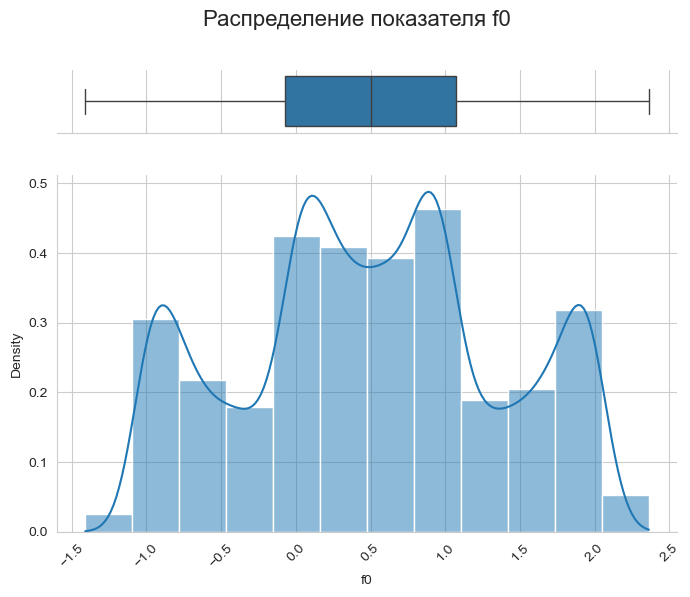

медиана: 0.5023604550688835 
среднее: 0.5 
min: -1.408605306026996 
max: 2.362330810854224 
верхний порог выбросов: 2.9 
нижний порог выбросов: -1.9 
Q1: -0.1 
Q3: 1.1
>>--<< >>--<< >>--<< >>--<< >>--<< >>--<< >>--<< >>--<< >>--<< >>--<< 


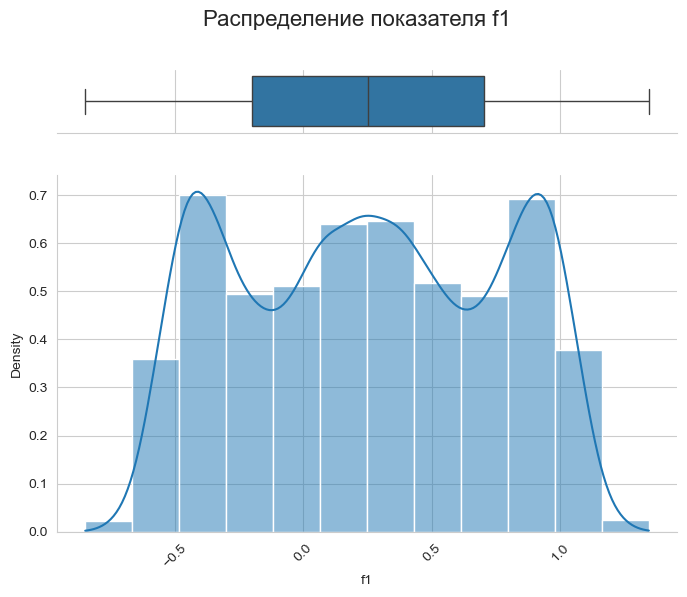

медиана: 0.25025228798345783 
среднее: 0.3 
min: -0.8482184970082173 
max: 1.343769333804496 
верхний порог выбросов: 2.05 
нижний порог выбросов: -1.55 
Q1: -0.2 
Q3: 0.7
>>--<< >>--<< >>--<< >>--<< >>--<< >>--<< >>--<< >>--<< >>--<< >>--<< 


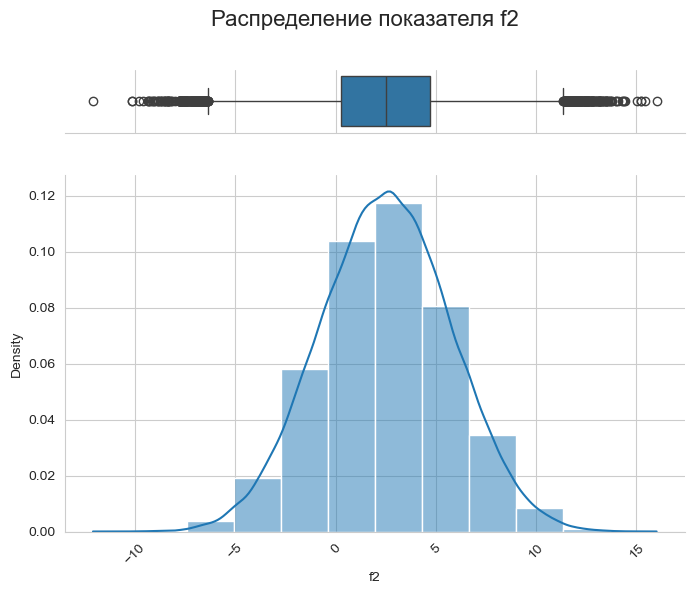

медиана: 2.5159691067559757 
среднее: 2.5 
min: -12.08832811806336 
max: 16.003790007695365 
верхний порог выбросов: 11.3 
нижний порог выбросов: -6.3 
Q1: 0.3 
Q3: 4.7
>>--<< >>--<< >>--<< >>--<< >>--<< >>--<< >>--<< >>--<< >>--<< >>--<< 


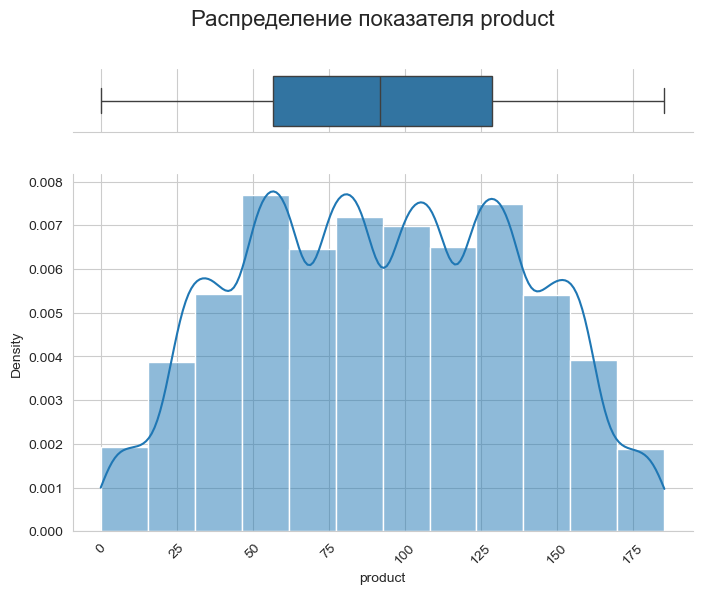

медиана: 91.84997204396296 
среднее: 92.5 
min: 0.0 
max: 185.3643474222929 
верхний порог выбросов: 236.75 
нижний порог выбросов: -51.65 
Q1: 56.5 
Q3: 128.6
>>--<< >>--<< >>--<< >>--<< >>--<< >>--<< >>--<< >>--<< >>--<< >>--<< 


In [16]:
print('Значения датасета district_0:')
for i in district_0.select_dtypes(include=[np.number]).columns:
    data_boxplot (district_0, i, 'Распределение показателя')
    print('>>--<< >>--<< ' * 5)

в датасете `district_0` обнаружены выбросы у показателя `f2`

Значения датасета district_1:


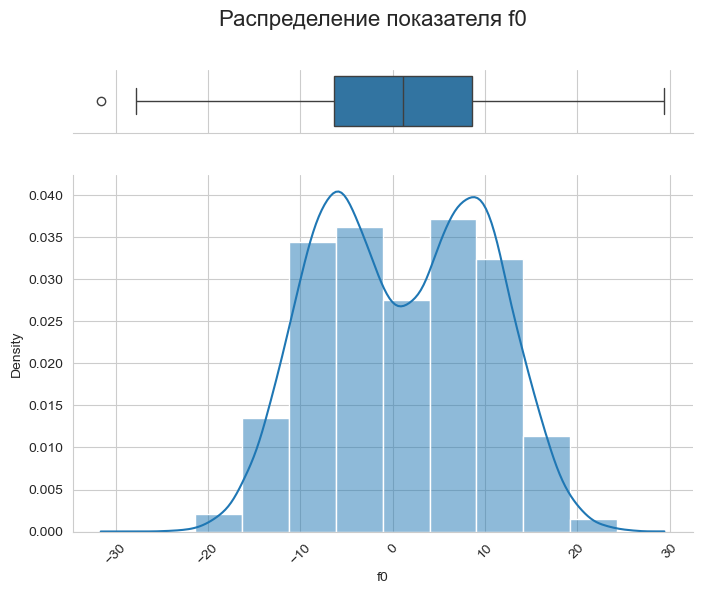

медиана: 1.1530552313242992 
среднее: 1.1 
min: -31.609576019167687 
max: 29.42175461390372 
верхний порог выбросов: 30.95 
нижний порог выбросов: -28.65 
Q1: -6.3 
Q3: 8.6
>>--<< >>--<< >>--<< >>--<< >>--<< >>--<< >>--<< >>--<< >>--<< >>--<< 


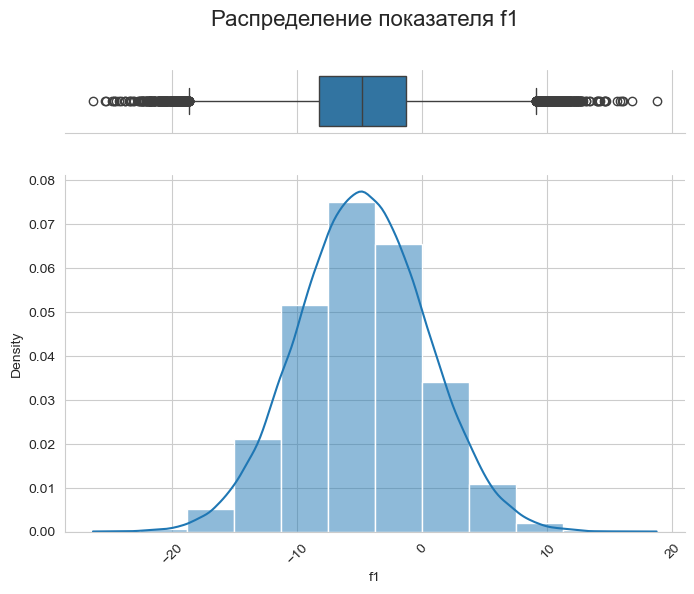

медиана: -4.813171838262699 
среднее: -4.8 
min: -26.358598008345872 
max: 18.73406263373076 
верхний порог выбросов: 9.2 
нижний порог выбросов: -18.8 
Q1: -8.3 
Q3: -1.3
>>--<< >>--<< >>--<< >>--<< >>--<< >>--<< >>--<< >>--<< >>--<< >>--<< 


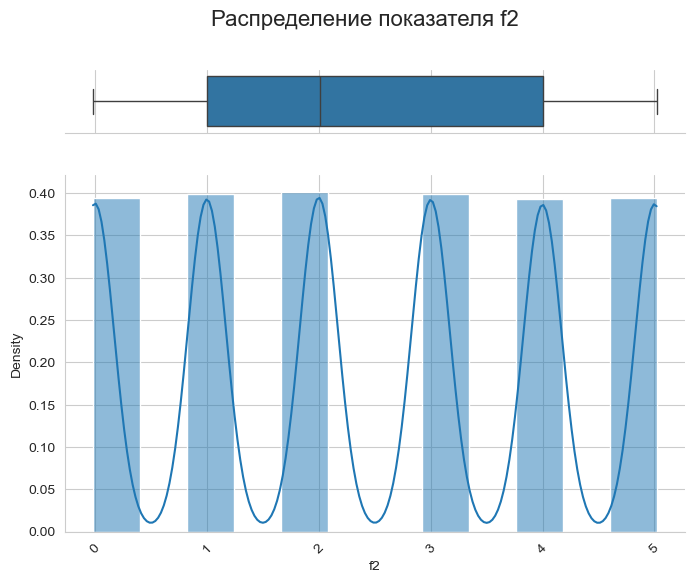

медиана: 2.0114785491201994 
среднее: 2.5 
min: -0.0181440867134202 
max: 5.019720555223062 
верхний порог выбросов: 8.5 
нижний порог выбросов: -3.5 
Q1: 1.0 
Q3: 4.0
>>--<< >>--<< >>--<< >>--<< >>--<< >>--<< >>--<< >>--<< >>--<< >>--<< 


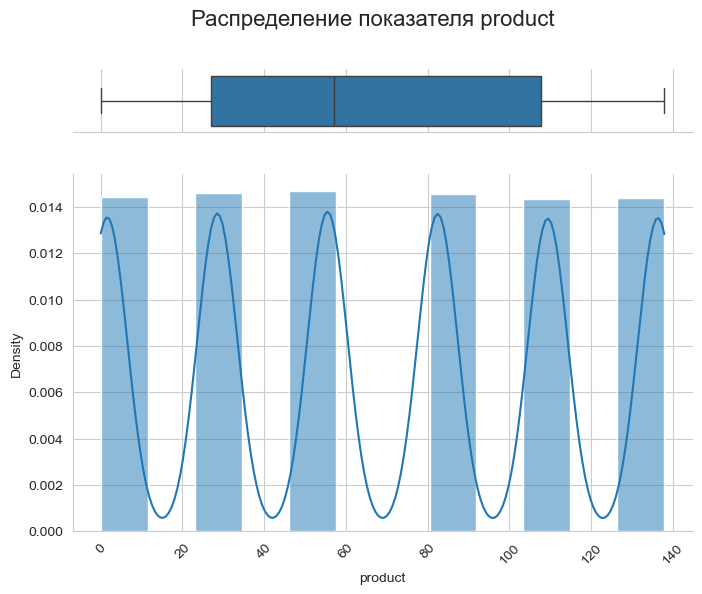

медиана: 57.08562464628662 
среднее: 68.8 
min: 0.0 
max: 137.94540774090564 
верхний порог выбросов: 229.0 
нижний порог выбросов: -94.2 
Q1: 27.0 
Q3: 107.8
>>--<< >>--<< >>--<< >>--<< >>--<< >>--<< >>--<< >>--<< >>--<< >>--<< 


In [17]:
print('Значения датасета district_1:')
for i in district_1.select_dtypes(include=[np.number]).columns:
    data_boxplot (district_1, i, 'Распределение показателя')
    print('>>--<< >>--<< ' * 5)

гисторграмма выявила необычный характер наблюдений в `district_1`: данные измерений, которые должны быть непрерывными, здесь отображаются как дискретные величины. возможно, некорректные настройки измерительного оборудования, либо что-то случилось в процессе выгрузки информации.

так как в данном случае у нас нет возможности уточнить, в чём может быть причина, не будем "выравнивать" данные наугад, пока оставим, как есть, и проверим следующий регион.

Значения датасета district_2:


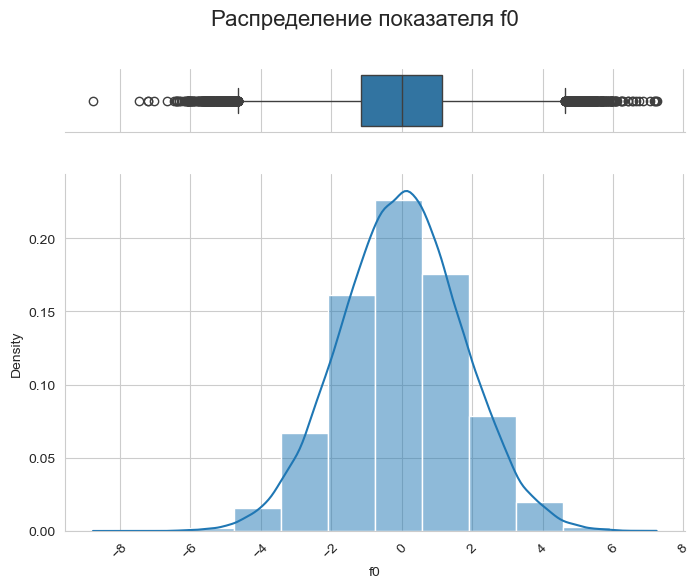

медиана: 0.0094235897936458 
среднее: 0.0 
min: -8.760003624213763 
max: 7.23826247979405 
верхний порог выбросов: 4.8 
нижний порог выбросов: -4.8 
Q1: -1.2 
Q3: 1.2
>>--<< >>--<< >>--<< >>--<< >>--<< >>--<< >>--<< >>--<< >>--<< >>--<< 


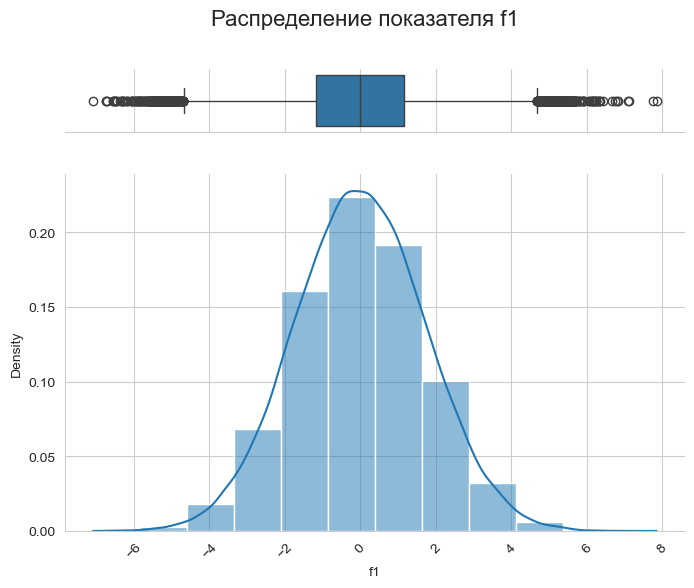

медиана: -0.00948216307443055 
среднее: -0.0 
min: -7.084019760867246 
max: 7.844801270084258 
верхний порог выбросов: 4.8 
нижний порог выбросов: -4.8 
Q1: -1.2 
Q3: 1.2
>>--<< >>--<< >>--<< >>--<< >>--<< >>--<< >>--<< >>--<< >>--<< >>--<< 


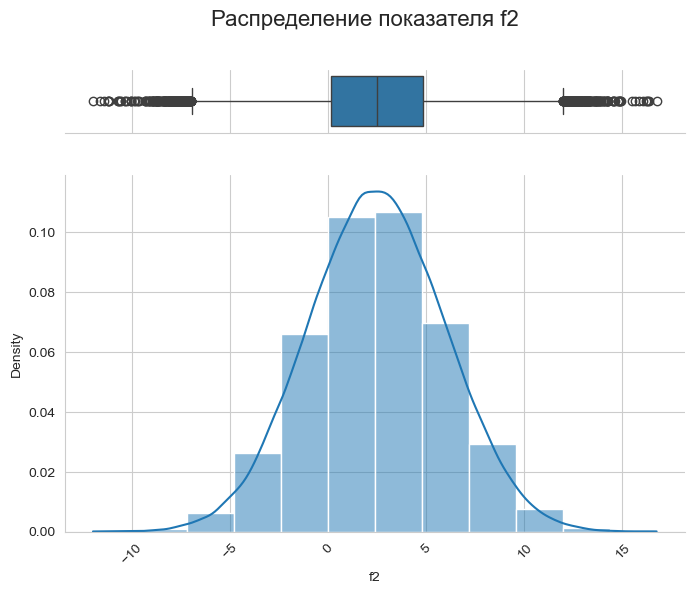

медиана: 2.4842358439369527 
среднее: 2.5 
min: -11.97033454147699 
max: 16.73940205869952 
верхний порог выбросов: 12.1 
нижний порог выбросов: -7.1 
Q1: 0.1 
Q3: 4.9
>>--<< >>--<< >>--<< >>--<< >>--<< >>--<< >>--<< >>--<< >>--<< >>--<< 


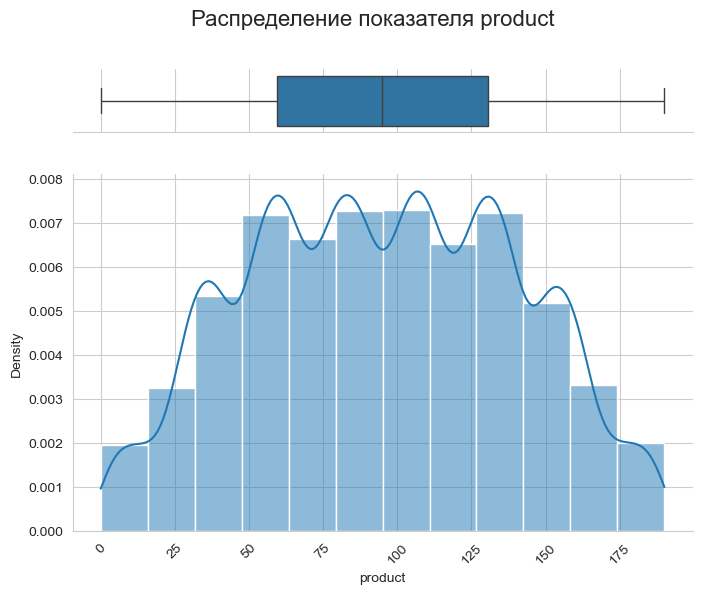

медиана: 94.92561258990247 
среднее: 95.0 
min: 0.0 
max: 190.0298383433513 
верхний порог выбросов: 237.25 
нижний порог выбросов: -47.15 
Q1: 59.5 
Q3: 130.6
>>--<< >>--<< >>--<< >>--<< >>--<< >>--<< >>--<< >>--<< >>--<< >>--<< 


In [18]:
print('Значения датасета district_2:')
for i in district_2.select_dtypes(include=[np.number]).columns:
    data_boxplot (district_2, i, 'Распределение показателя')
    print('>>--<< >>--<< ' * 5)

в `district_2` также замечены выбросы как для `f1`, так и для `f2`

дополнительно проведём квантильные построения, чтобы посмотреть как распределены данные (гистограмма второго датасета `district_1` позволяет предположить неравномерность распределения данных).

Q-Q plot для числовых переменных датасета district_0


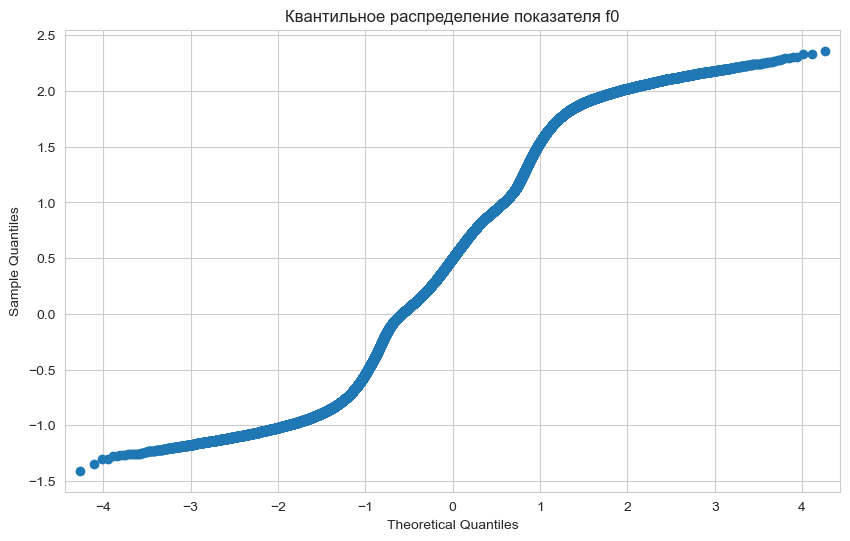

>>--<< >>--<< >>--<< >>--<< >>--<< >>--<< >>--<< >>--<< >>--<< >>--<< 


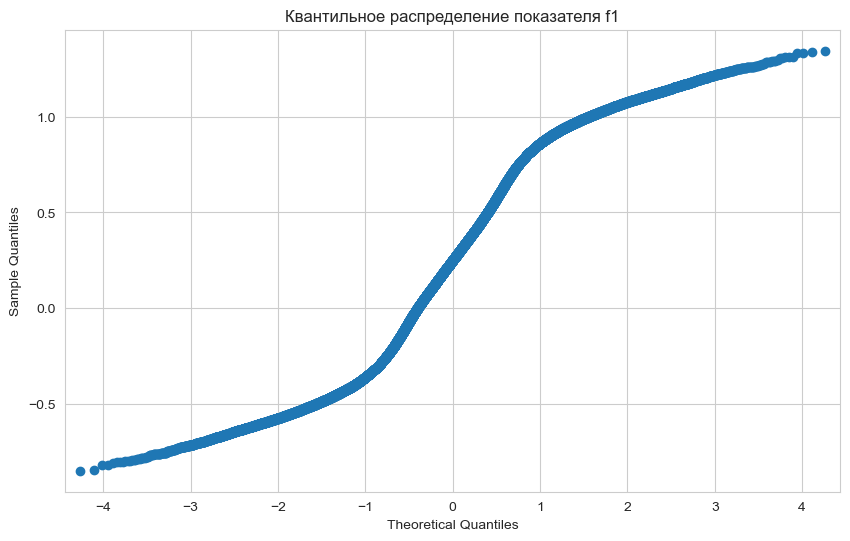

>>--<< >>--<< >>--<< >>--<< >>--<< >>--<< >>--<< >>--<< >>--<< >>--<< 


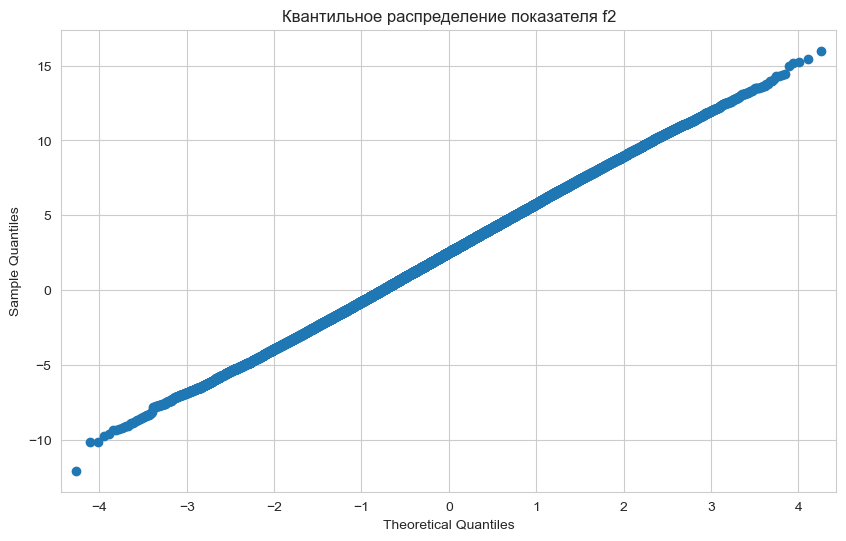

>>--<< >>--<< >>--<< >>--<< >>--<< >>--<< >>--<< >>--<< >>--<< >>--<< 


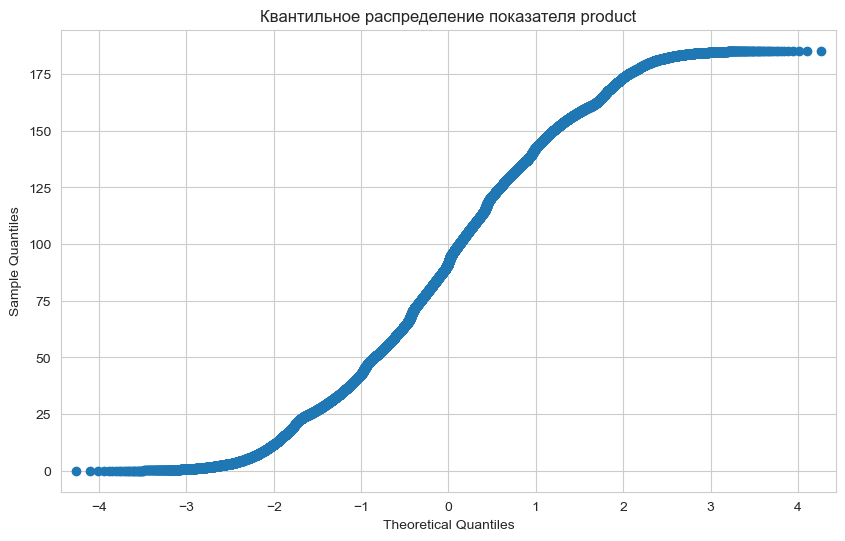

>>--<< >>--<< >>--<< >>--<< >>--<< >>--<< >>--<< >>--<< >>--<< >>--<< 


In [19]:
print("Q-Q plot для числовых переменных датасета district_0")
for i in district_0.select_dtypes(include=[np.number]).columns:
    sm.qqplot(district_0[i])
    plt.title(f'Квантильное распределение показателя {i}')
    plt.show()
    print('>>--<< >>--<< ' * 5)

* f0 в нижней части фактичкские значения слишком высокие, а в верхних точках слишком низкие,
* f1 в нижней части фактические значения слишком высокие, а в верхних точках слишком низкие,
* f2 нормально распрелелен

Q-Q plot для числовых переменных датасета district_1


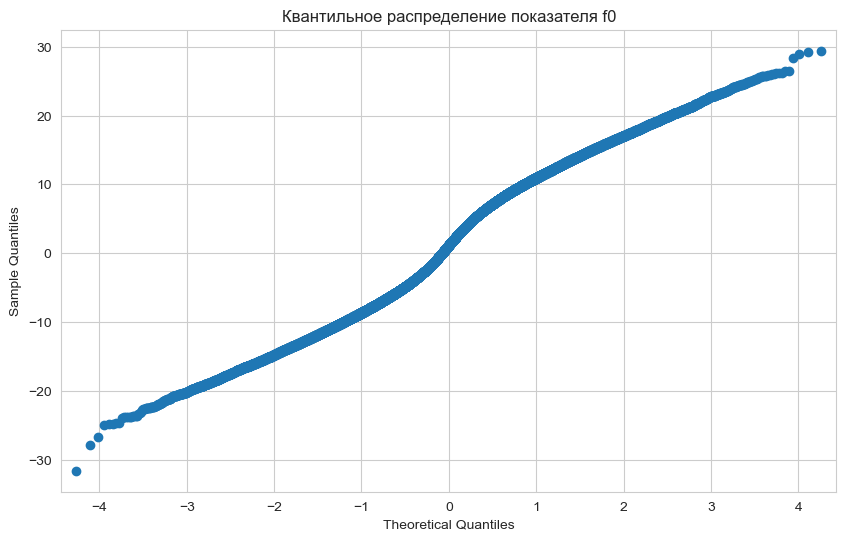

>>--<< >>--<< >>--<< >>--<< >>--<< >>--<< >>--<< >>--<< >>--<< >>--<< 


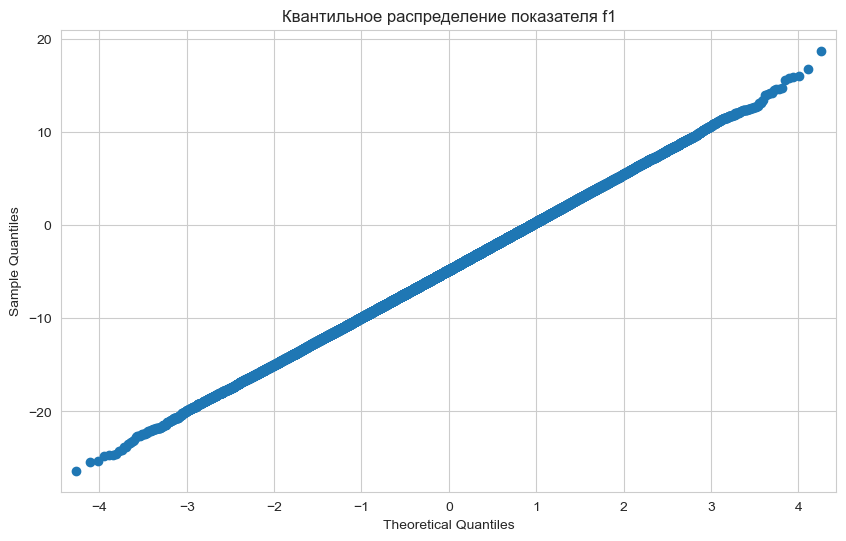

>>--<< >>--<< >>--<< >>--<< >>--<< >>--<< >>--<< >>--<< >>--<< >>--<< 


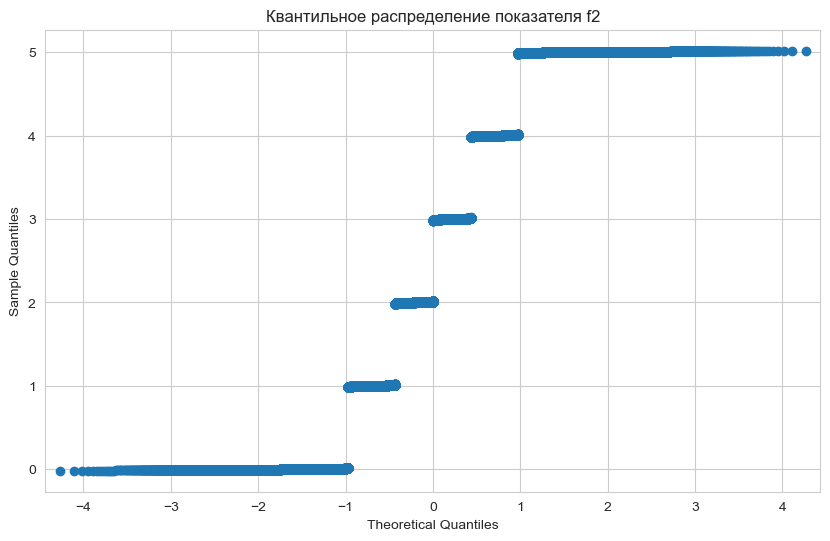

>>--<< >>--<< >>--<< >>--<< >>--<< >>--<< >>--<< >>--<< >>--<< >>--<< 


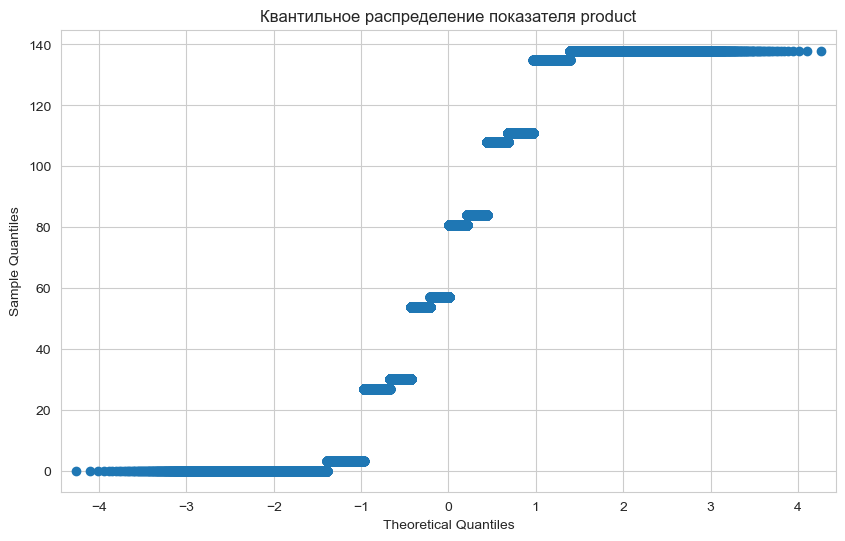

>>--<< >>--<< >>--<< >>--<< >>--<< >>--<< >>--<< >>--<< >>--<< >>--<< 


In [20]:
print("Q-Q plot для числовых переменных датасета district_1")
for i in district_1.select_dtypes(include=[np.number]).columns:
    sm.qqplot(district_1[i])
    plt.title(f'Квантильное распределение показателя {i}')
    plt.show()
    print('>>--<< >>--<< ' * 5)

* f0 нормально распрелелен
* f1 нормально распрелелен
* f2 как видно из гистограмм выше, имеет неравномерные данные, однако мы решили не исправлять его, наугад, не зная природы искажения данных

Q-Q plot для числовых переменных датасета district_2


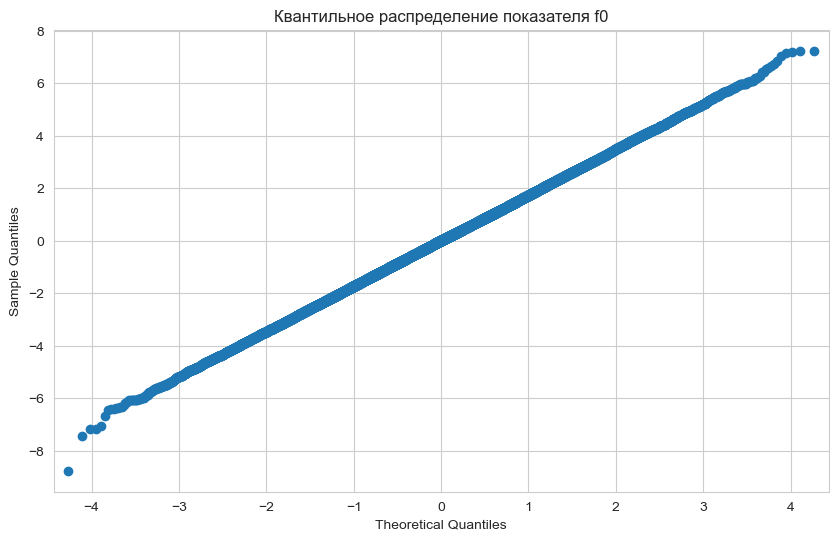

>>--<< >>--<< >>--<< >>--<< >>--<< >>--<< >>--<< >>--<< >>--<< >>--<< 


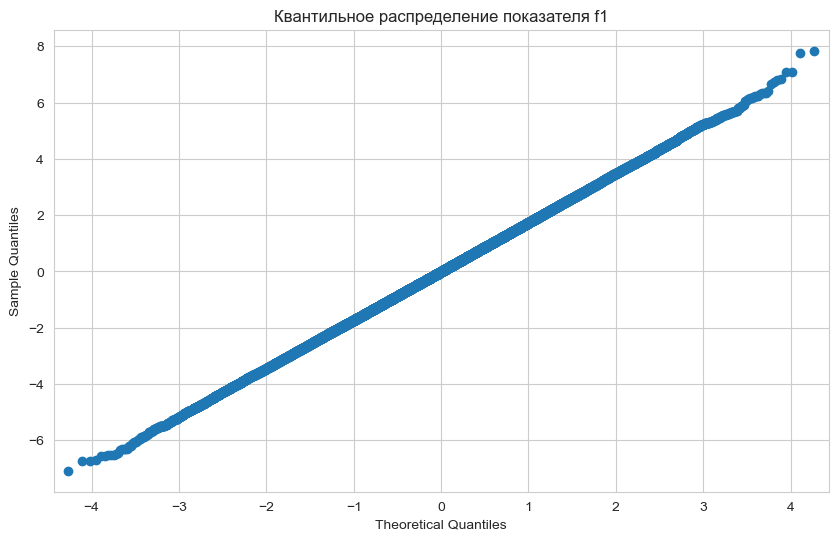

>>--<< >>--<< >>--<< >>--<< >>--<< >>--<< >>--<< >>--<< >>--<< >>--<< 


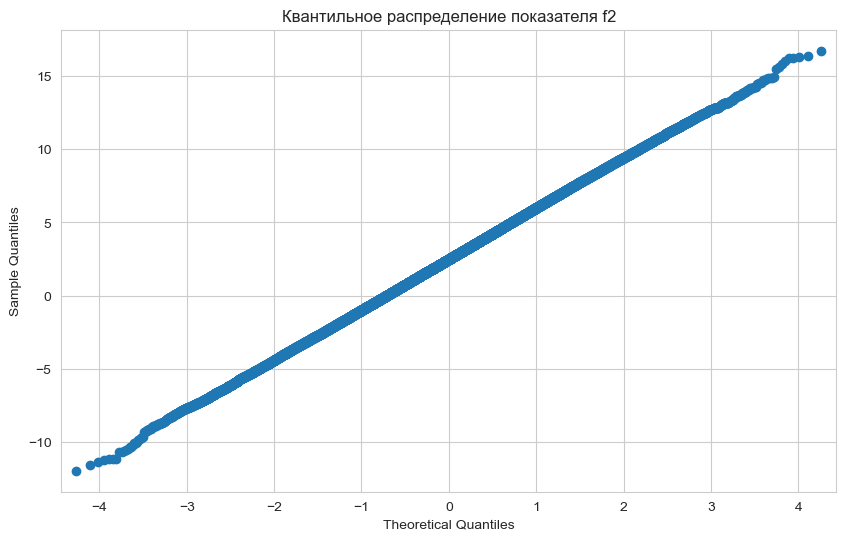

>>--<< >>--<< >>--<< >>--<< >>--<< >>--<< >>--<< >>--<< >>--<< >>--<< 


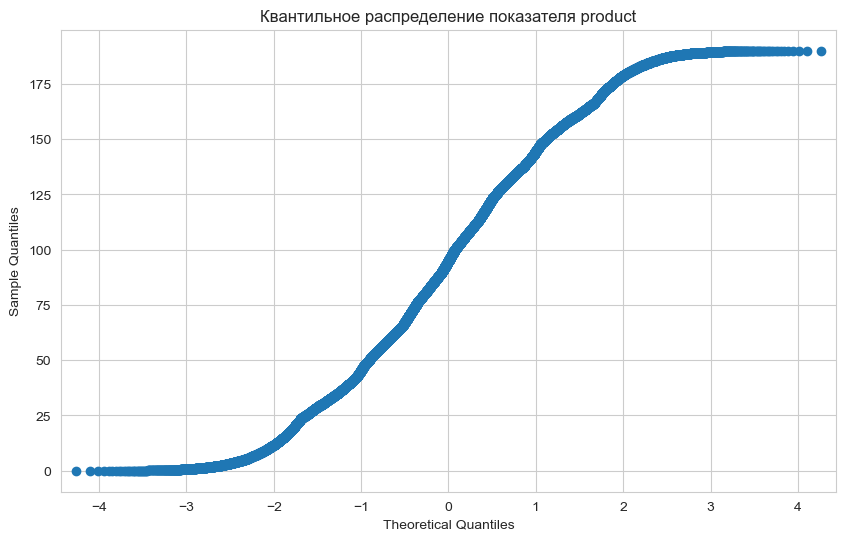

>>--<< >>--<< >>--<< >>--<< >>--<< >>--<< >>--<< >>--<< >>--<< >>--<< 


In [22]:
print("Q-Q plot для числовых переменных датасета district_2")
for i in district_2.select_dtypes(include=[np.number]).columns:
    sm.qqplot(district_2[i])
    plt.title(f'Квантильное распределение показателя {i}')
    plt.show()
    print('>>--<< >>--<< ' * 5)

в регионе `district_2` видим нормальное распределение у всех f-признаков

теперь проверим данные на мультиколлинеарность. предлагаю выполнить эту проверку дважды: до удаления выбросов и после.

In [23]:
X = sm.add_constant(district_0.select_dtypes(include=[np.number]))

print('VIF для каждого показателя district_0')
print()
VIFs = pd.DataFrame()
VIFs['variable'] = X.columns
VIFs['VIF'] = [variance_inflation_factor(X.values, i) for i in range(X.shape[1])]
print(VIFs)

X = sm.add_constant(district_1.select_dtypes(include=[np.number]))
print('VIF для каждого показателя district_1')
print()
VIFs = pd.DataFrame()
VIFs['variable'] = X.columns
VIFs['VIF'] = [variance_inflation_factor(X.values, i) for i in range(X.shape[1])]
print(VIFs)

X = sm.add_constant(district_2.select_dtypes(include=[np.number]))
print('VIF для каждого показателя district_2')
print()
VIFs = pd.DataFrame()
VIFs['variable'] = X.columns
VIFs['VIF'] = [variance_inflation_factor(X.values, i) for i in range(X.shape[1])]
print(VIFs)

VIF для каждого показателя district_0

  variable       VIF
0    const  6.861281
1       f0  1.248703
2       f1  1.276589
3       f2  1.323671
4  product  1.380659
VIF для каждого показателя district_1

  variable          VIF
0    const     7.561536
1       f0     3.163234
2       f1     1.049803
3       f2  2660.141618
4  product  2662.652617
VIF для каждого показателя district_2

  variable       VIF
0    const  5.571816
1       f0  1.000004
2       f1  1.000003
3       f2  1.248132
4  product  1.248137


удалим выбросы

In [24]:
del_data = [(district_0, 'f2'), 
           (district_1, 'f1'),
           (district_2, 'f0'),
           (district_2, 'f1'),
           (district_2, 'f2'),]   

for data,column in del_data:
    index = remove_outliers(data, column)
    data.drop(index, axis=0, inplace=True)
    
district_0 = district_0.reset_index(drop=True)
district_1 = district_1.reset_index(drop=True)
district_2 = district_2.reset_index(drop=True)

print(f"\nРазмер district_0: {district_0.shape} \n"
      f"Размер district_1: {district_1.shape} \n"
      f"Размер district_2: {district_2.shape} \n"
     )

количество удалённых строк: 506
количество удалённых строк: 636
количество удалённых строк: 733
количество удалённых строк: 682
количество удалённых строк: 582

Размер district_0: (99494, 5) 
Размер district_1: (99364, 5) 
Размер district_2: (98003, 5) 



удаление выбросов привело к уменшению датасетов, однако в рамках статистической погрешности.

In [25]:
X = sm.add_constant(district_0.select_dtypes(include=[np.number]))

print('VIF для каждого показателя district_0')
print()
VIFs = pd.DataFrame()
VIFs['variable'] = X.columns
VIFs['VIF'] = [variance_inflation_factor(X.values, i) for i in range(X.shape[1])]
print(VIFs)

X = sm.add_constant(district_1.select_dtypes(include=[np.number]))
print('VIF для каждого показателя district_1')
print()
VIFs = pd.DataFrame()
VIFs['variable'] = X.columns
VIFs['VIF'] = [variance_inflation_factor(X.values, i) for i in range(X.shape[1])]
print(VIFs)

X = sm.add_constant(district_2.select_dtypes(include=[np.number]))
print('VIF для каждого показателя district_2')
print()
VIFs = pd.DataFrame()
VIFs['variable'] = X.columns
VIFs['VIF'] = [variance_inflation_factor(X.values, i) for i in range(X.shape[1])]
print(VIFs)

VIF для каждого показателя district_0

  variable       VIF
0    const  6.857049
1       f0  1.248687
2       f1  1.276432
3       f2  1.317430
4  product  1.374340
VIF для каждого показателя district_1

  variable          VIF
0    const     7.611298
1       f0     3.163059
2       f1     1.047858
3       f2  2657.428606
4  product  2659.922763
VIF для каждого показателя district_2

  variable       VIF
0    const  5.549105
1       f0  1.000013
2       f1  1.000003
3       f2  1.241729
4  product  1.241740


нам удалось незначительно снизить показатель мультиколлинеарности

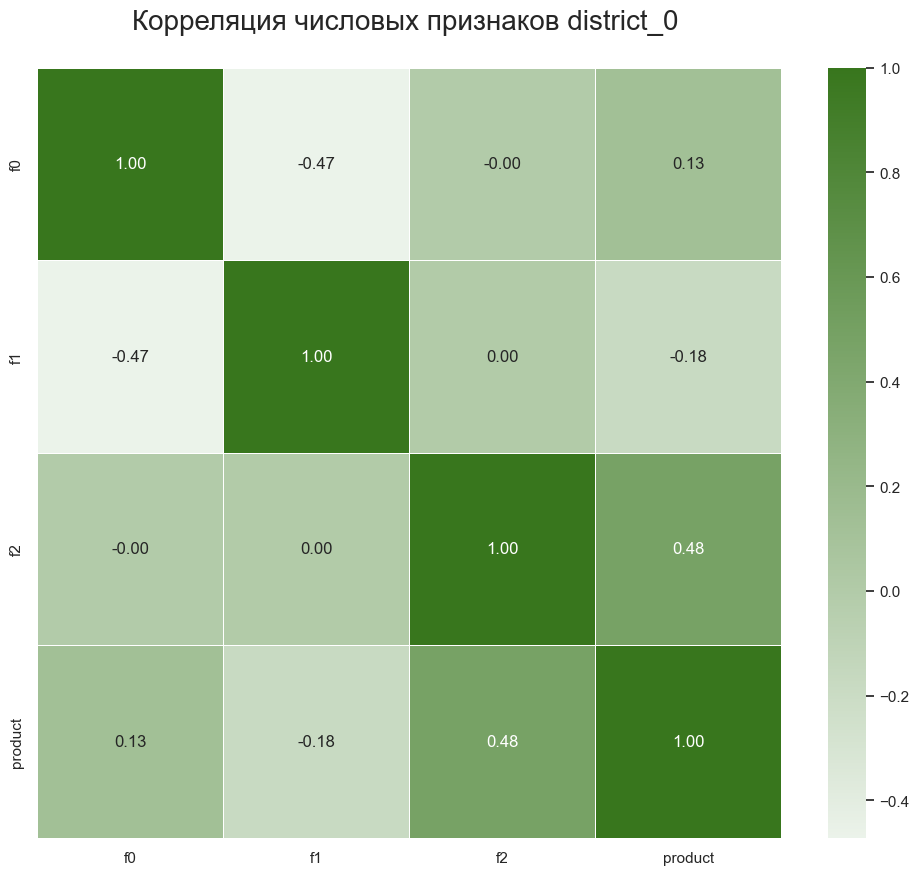

In [26]:
green_cmap = sns.light_palette("#38761d", as_cmap=True)
sns.set(rc={"figure.figsize": (12, 10)})
sns.heatmap(district_0.select_dtypes(include=['number'])
            .corr('spearman'), 
            annot=True, fmt='.2f', 
            cmap=green_cmap, 
            linewidths=0.5
           )
plt.title('Корреляция числовых признаков district_0 \n', fontsize=20)
plt.show()

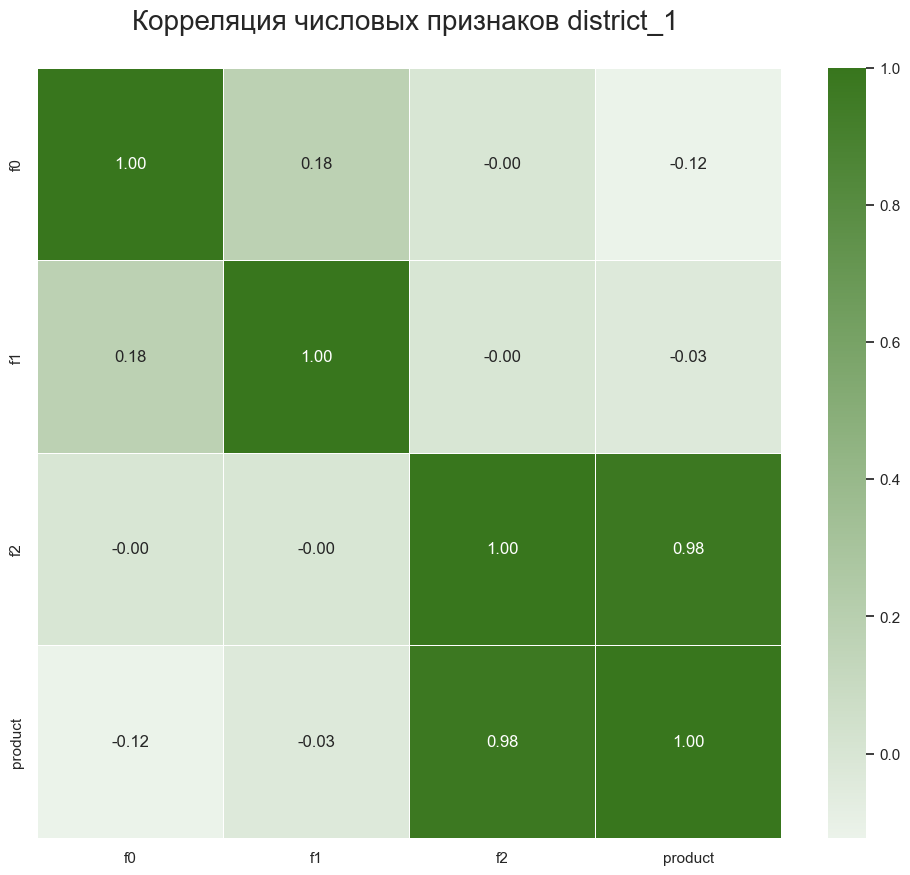

In [27]:
green_cmap = sns.light_palette("#38761d", as_cmap=True)
sns.set(rc={"figure.figsize": (12, 10)})
sns.heatmap(district_1.select_dtypes(include=['number'])
            .corr('spearman'), 
            annot=True, fmt='.2f', 
            cmap=green_cmap, 
            linewidths=0.5
           )
plt.title('Корреляция числовых признаков district_1 \n', fontsize=20)
plt.show()

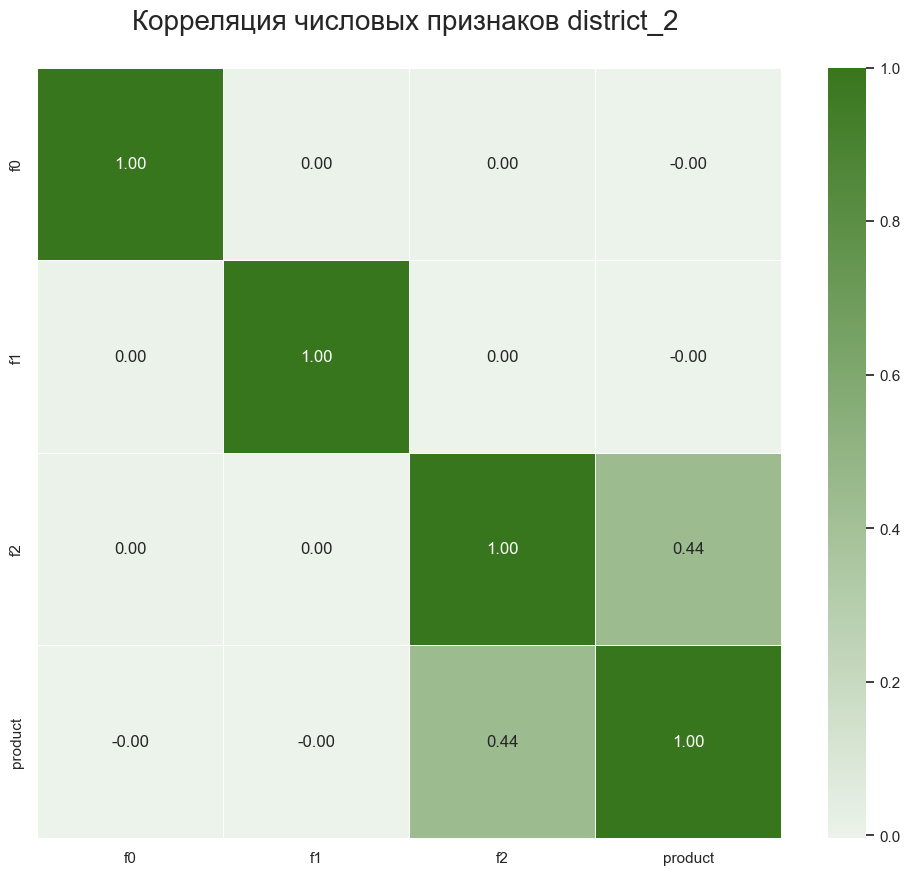

In [28]:
green_cmap = sns.light_palette("#38761d", as_cmap=True)
sns.set(rc={"figure.figsize": (12, 10)})
sns.heatmap(district_2.select_dtypes(include=['number'])
            .corr('spearman'), 
            annot=True, fmt='.2f', 
            cmap=green_cmap, 
            linewidths=0.5
           )
plt.title('Корреляция числовых признаков district_2 \n', fontsize=20)
plt.show()

в датасетах присутствует отрицательная, слабоотрицательная и слабоположительная корреляция признаков. Однако сильно выделяется датасет `district_2`, где признак f2 имеет высокую корреляцию с данными.

**промежуточный вывод**
* в датасете `district_2` обнаружена корреляция с целевым признаком, при этом признак f2 демонстрирует корреляцию во всех датасетах. 
* ропущенных значений и дублей не выявлего
* значения признаков лежат как в положительных, так и в отрицательных диапазонах
* в датасете `district_1` рпизнак f0 имеет `VIF=3.16`, что является максимальным среди всех датасетов.
* для удаления выбросов применена обработка квантилей 0.25 и 0.75

итого:  
датасеты содержат значимую информацию с различной степенью корреляции признаков, что необходимо учитывать при дальнейшей обработке и моделировании. делая финальные выводы, будем учитывать нехаракерное для непрерывных данных распределение признака f2 в датасете `district_1`.

## Обучение и проверка модели

In [30]:
def learning(df):
    X = df.drop(['id','product'], axis = 1)
    y = df['product']
    X_train, X_valid, y_train, y_valid = train_test_split(X, 
                                                    y, 
                                                    test_size=TEST_SIZE, 
                                                    random_state=RANDOM)
    
    
    pipeline = make_pipeline(StandardScaler(), LinearRegression())
    pipeline.fit(X_train, y_train)
    predict_valid = pipeline.predict(X_valid)
    score = mean_squared_error(y_valid,  predict_valid)**0.5
    predicted_mean = predict_valid.sum() / len(predict_valid)
    all_pred = pipeline.predict(X)
    return y_valid, predict_valid, score, predicted_mean, all_pred

In [31]:
y_valid_0, predict_valid_0, score_0, predicted_mean_0, all_pred_0  = learning(district_0)
score_0

37.815104778634264

In [32]:
y_valid_1, predict_valid_1, score_1, predicted_mean_1, all_pred_1  = learning(district_1)
score_1

0.8911478860562418

In [33]:
y_valid_2, predict_valid_2, score_2, predicted_mean_2, all_pred_2 = learning(district_2)
score_2

40.12959008344122

In [34]:
district_0['all_predict'] = all_pred_0
district_1['all_predict'] = all_pred_1
district_2['all_predict'] = all_pred_2

In [35]:
print(f"датасет district_0 \n"
      f"Средний запас: {predicted_mean_0} \n"
      f"RMSE модели: {score_0} \n \n"
      f"датасет district_1 \n"
      f"Средний запас: {predicted_mean_1} \n"
      f"RMSE модели: {score_1} \n \n"
      f"датасет district_2 \n"
      f"Средний запас: {predicted_mean_2} \n"
      f"RMSE модели: {score_2}"
     )

датасет district_0 
Средний запас: 92.3505469646708 
RMSE модели: 37.815104778634264 
 
датасет district_1 
Средний запас: 68.54948307873167 
RMSE модели: 0.8911478860562418 
 
датасет district_2 
Средний запас: 94.95178110761832 
RMSE модели: 40.12959008344122


Вывод: Таким образом, можно составить следующий рейтинг по среднему запасу:
* Второй регион - 94.95 тыс. баррелей.
* Нулевой регион - 92.35 тыс. баррелей.
* Первый регион - 68.5 тыс. баррелей.

И по ошибке RMSE:
* Первый регион - 0.89.
* Нулевой регион - 37.8.
* Второй регион - 40.13.

## Подготовка к расчёту прибыли

Условия задачи:

1. Для обучения модели подходит только линейная регрессия (остальные — недостаточно предсказуемые).
2. При разведке региона исследуют 500 точек, из которых с помощью машинного обучения выбирают 200 лучших для разработки.
3. Бюджет на разработку скважин в регионе — 10 млрд рублей.
4. При нынешних ценах один баррель сырья приносит 450 рублей дохода. Доход с каждой единицы продукта составляет 450 тыс. рублей, поскольку объём указан в тысячах баррелей.
5. После оценки рисков нужно оставить лишь те регионы, в которых вероятность убытков меньше 2.5%. Среди них выбирают регион с наибольшей средней прибылью.

In [36]:
POINTS = 500       # точки (общее количество)
BEST_POINTS = 200  # точки для разработки
BUDGET = 10**10    # бюджет на разработку
COST =  1000 * 450 # стоимость тысячи баррелей сырья

In [37]:
cost_per_point = BUDGET / BEST_POINTS
min_product = cost_per_point / COST
print('Минимальный объём сырья для безубыточной разработки новой скважины: {:.2f}'.format(min_product))

Минимальный объём сырья для безубыточной разработки новой скважины: 111.11


In [38]:
print(f"Разница между предсказанным объёмом сырья и минимально необходимым: \n"
      f"district_0: {(predicted_mean_0 - min_product):.2f} \n"
      f"district_1: {(predicted_mean_1 - min_product):.2f} \n"
      f"district_2: {(predicted_mean_2 - min_product):.2f} \n"
     )      

Разница между предсказанным объёмом сырья и минимально необходимым: 
district_0: -18.76 
district_1: -42.56 
district_2: -16.16 



теперь посмотрим на разницу между фактическим объёмом сырья и минимально необходимым.  
среднее фактическое в каждом регионе будем считать из 200 лучших скважин (по аналогии с условиями задачи) и для нагляднособерём все результаты в один датафрейм

In [40]:
delta = {
    "predicted_mean": [
        predicted_mean_0,
        predicted_mean_1,
        predicted_mean_2
    ],
    "delta_1": [
        round(predicted_mean_0 - min_product, 2),
        round(predicted_mean_1 - min_product, 2),
        round(predicted_mean_2 - min_product, 2)
    ],
    "fact_mean": [
        y_valid_0.sort_values(ascending=False).head(200).mean(),
        y_valid_1.sort_values(ascending=False).head(200).mean(),
        y_valid_2.sort_values(ascending=False).head(200).mean()
    ],
    "delta_2": [
        round(y_valid_0.sort_values(ascending=False).head(200).mean() - min_product, 2),
        round(y_valid_1.sort_values(ascending=False).head(200).mean() - min_product, 2),
        round(y_valid_2.sort_values(ascending=False).head(200).mean() - min_product, 2)
    ]
}

delta_summary = pd.DataFrame(
    delta,
    index=["district_0", "district_1", "district_2"]
)

delta_summary

,predicted_mean,delta_1,fact_mean,delta_2
district_0,92.350547,-18.76,183.358571,72.25
district_1,68.549483,-42.56,137.945408,26.83
district_2,94.951781,-16.16,187.970699,76.86


в каждом из трёх регионов **предсказанный** средний запас сырья скважины меньше минимально необходимого, наибольшую разницу демонстрирует `district_1`, где до безубыточной разработки не хватает `42.56` тысяч баррелей. однако мы помним, что при анализе признаков district_1 выявлено аномальное распределение, соответственно, прогноз по этому региону менее достоверен.

наиболее высокий **фактический** средний объём сырья двухсот лучших точек демонстрирует `district_2` (разница 76.86), этот же регион показывает наименьший недостаток запасов до безубыточной разработки (не хватило всего `16.16` тысяч баррелей).

в целом можно сказать, что модель во всех регионах недооценивает запасы сырья, однако анализ фактических данных по топ-200 скважинам показывает, что реальный объём в некоторых регионах способен компенсировать этот разрыв. пока `district_2` выглядит наиболее надёжным кандидатом.

## Расчёт прибыли и рисков

In [42]:
def profit(df_subsample, count, barrel_price, money):
    preds_sort_idx = df_subsample['pred'].sort_values(ascending=False).index
    selected = df_subsample.loc[preds_sort_idx, 'target'].iloc[:count]

    return int((barrel_price * selected.sum()) - money)

In [43]:
def bootstrap(target, predicted, best_points, cost_per_point, budget):
    values = []
    df_all = (
        pd.concat([target.rename('target'), predicted.rename('pred')], axis=1, join='inner')
        .dropna()
    )
    
    for i in range(1000):
        df_subsample = df_all.sample(n=POINTS, replace=True, random_state=state)
        # target_subsample = target.sample(n=POINTS, replace=True, random_state=state)
        # pred_subsample = predicted[target_subsample.index]

        values.append(profit(df_subsample,
                             # target_subsample, 
                             # pred_subsample,
                             BEST_POINTS,
                             COST,
                             BUDGET))
        
    values = pd.Series(values)
    values_mean = int(values.mean())
    lower = int(values.quantile(0.025))
    upper = int(values.quantile(0.975))
    risk = (len(values[values<0]) / len(values)) * 100
    return values_mean, lower, upper, risk

In [44]:
values_mean_0, lower_0, upper_0, risk_0 = bootstrap(
    y_valid_0, 
    district_0['all_predict'], 
    BEST_POINTS, 
    cost_per_point, BUDGET
)

values_mean_1, lower_1, upper_1, risk_1 = bootstrap(
    y_valid_1, 
    district_1['all_predict'], 
    BEST_POINTS, 
    cost_per_point, 
    BUDGET
)

values_mean_2, lower_2, upper_2, risk_2 = bootstrap(
    y_valid_2, 
    district_2['all_predict'], 
    BEST_POINTS, 
    cost_per_point, BUDGET
)

In [45]:
print(f"district_0 \n"
      f"cредняя прибыль: {values_mean_0} \n"
      f"95% доверительный интервал: от {lower_0} до {upper_0}\n" 
      f"риск убытков: {risk_0:.1f}% \n\n"
      f"district_1 \n"
      f"cредняя прибыль: {values_mean_1} \n" 
      f"95% доверительный интервал: от {lower_1} до {upper_1} \n"
      f"риск убытков: {risk_1:.1f}% \n \n"
      f"district_2 \n"
      f"cредняя прибыль: {values_mean_2} \n"
      f"95% доверительный интервал: от {lower_2} до {upper_2} \n" 
      f"риск убытков: {risk_2:.1f}%"
     )

district_0 
cредняя прибыль: 412922476 
95% доверительный интервал: от -92734758 до 949434431
риск убытков: 5.9% 

district_1 
cредняя прибыль: 492301388 
95% доверительный интервал: от 71717312 до 914489286 
риск убытков: 1.0% 
 
district_2 
cредняя прибыль: 397350278 
95% доверительный интервал: от -116804523 до 918280108 
риск убытков: 7.2%


## Выводы

средняя прибыль лучших месторождений:
* нулевой регион &mdash; 412 922 476 рублей
* первый регион &mdash; 492 301 388 рублей
* второй регион &mdash; 397 350 278 рулей

95% доверительный интервал для средней прибыли 200 лучших месторождений:
* нулевой регион &mdash; от -92 734 758 до 949 434 431
* первый регион &mdash; от 71 717 312 до 914 489 286
* второй регион &mdash; от 141 181 437 до 920 540 318

риски убытков
* нулевой регион &mdash; 5.9%
* первый регион &mdash; 1.0%
* второй регион &mdash; 7.5%

в результате проведённого анализа можно сжделать вывод, что первый регион (`district_1`) обладает наибольшим потенциалом для разработки скважины по сравнению с другими регионами: выше рентабельность, более узкий интервал для прогнозируемой прибыли и самый низкий уровень риска. однако мы не можем полностью доверять полученным результатам, т.к. распределение данных в `district_1` говорит о недостаточно высоком качестве измерений. для более надёжного прогноза следует запросить данные по этому региону ещё раз и провести анализ повторно.